In [ ]:
!pip uninstall gshap -y

In [ ]:
!pip install git+https://github.com/dsbowen/gshap.git

In [ ]:
import numpy as np
import pandas as pd
import shap
import gshap
from gshap.intergroup import IntergroupDifference
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("hf://datasets/scikit-learn/adult-census-income/adult.csv")

df = df[['age', 'workclass', 'education', 'education.num', 'marital.status',
         'occupation', 'relationship', 'race', 'sex', 'capital.gain',
         'capital.loss', 'hours.per.week', 'native.country', 'income']]

df = pd.get_dummies(df, columns=['workclass', 'education', 'marital.status',
                                 'occupation', 'relationship', 'race', 'native.country'], drop_first=True)

df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

y = df['income']
X = df.drop(columns=['income'])

group = (df['sex'] == 'Male').astype(int)
X = X.drop(columns=['sex'])

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    X, y, group, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_mlp(X_train.shape[1])

print("Model training...")
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))
print("Model training completed!")

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


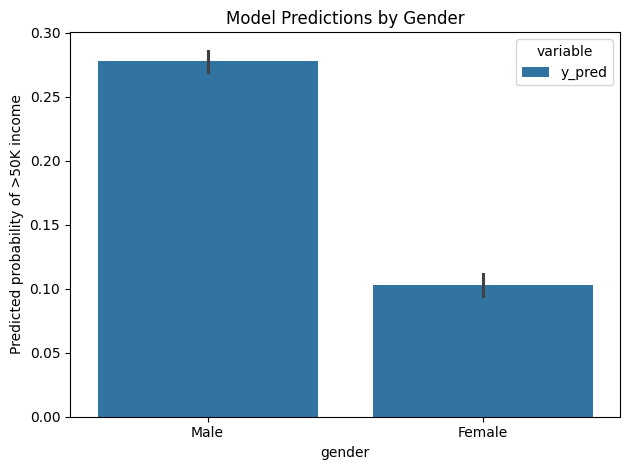

In [4]:
y_pred_test = model.predict(X_test_scaled).flatten()

df_pred = pd.DataFrame({
    'gender': group_test.replace({1: 'Male', 0: 'Female'}).values,
    'y_pred': y_pred_test
})
df_pred['id'] = df_pred.index
df_melt = df_pred.melt(id_vars=['id', 'gender'], value_vars=['y_pred'])

sns.barplot(x='gender', y='value', hue='variable', data=df_melt)
plt.ylabel('Predicted probability of >50K income')
plt.title('Model Predictions by Gender')
plt.tight_layout()
plt.show()

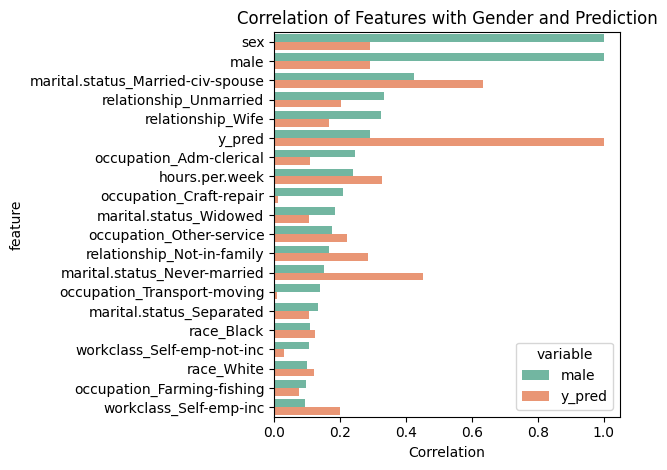

In [6]:
df_corr = pd.concat([X_test.reset_index(drop=True), group_test.reset_index(drop=True)], axis=1)
df_corr['male'] = df_corr['sex']
df_corr['y_pred'] = y_pred_test

corr_matrix = df_corr.corr()
corr_subset = corr_matrix[['male', 'y_pred']].abs().sort_values(by='male', ascending=False).head(20)
corr_subset = corr_subset.reset_index().rename(columns={'index': 'feature'})

corr_melt = corr_subset.melt(id_vars='feature', value_vars=['male', 'y_pred'], var_name='variable', value_name='correlation')


sns.barplot(x='correlation', y='feature', hue='variable', data=corr_melt, palette='Set2')
plt.xlabel('Correlation')
plt.title('Correlation of Features with Gender and Prediction')
plt.tight_layout()
plt.show()

In [7]:
predict_fn = lambda x: model(x, training=False).numpy().flatten()

sample_X = X_test_scaled[:100]
sample_group = group_test[:100]
background_X = X_train_scaled[:50]

g = IntergroupDifference(group=sample_group, distance="relative_mean_distance")
explainer = gshap.KernelExplainer(predict_fn, background_X, g)

gshap_values = explainer.gshap_values(sample_X, nsamples=50)

df_importance = pd.DataFrame({'Features': X.columns, 'G-SHAP': gshap_values})
df_importance = df_importance.sort_values('G-SHAP', ascending=False)

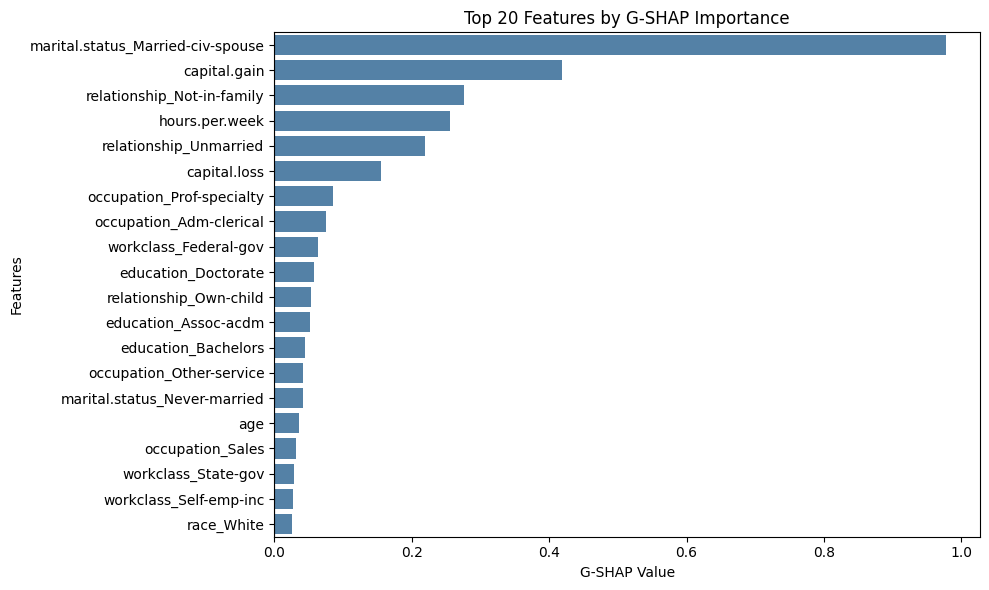


G-SHAP Summary Table (Top Features):


,Features,G-SHAP
29,marital.status_Married-civ-spouse,0.978029
2,capital.gain,0.418817
48,relationship_Not-in-family,0.275746
4,hours.per.week,0.255747
51,relationship_Unmarried,0.218845
3,capital.loss,0.155127
43,occupation_Prof-specialty,0.086051
34,occupation_Adm-clerical,0.075746
5,workclass_Federal-gov,0.064497
22,education_Doctorate,0.058205


In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(y='Features', x='G-SHAP', data=df_importance.head(20), color='steelblue')
plt.axvline(0, color='black', linestyle='--')
plt.title("Top 20 Features by G-SHAP Importance")
plt.xlabel("G-SHAP Value")
plt.tight_layout()
plt.show()

print("\nG-SHAP Summary Table (Top Features):")
display(df_importance.head(20))